# Solving for probe and object and scan position corrections

In [2]:
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import skimage, skimage.transform, skimage.data
import skimage.feature, skimage.restoration
from helper import *

In [1]:
%load_ext autoreload
%autoreload 2

## Generating the object, the probe, and the diffraction intensities (with Poisson noise) ##

In [3]:
# Generating the object and the probe. 
# For convenience, I am not setting the detector pixel pitch - just working directly with the object plane 
obj_npix = 128
probe_npix = 64
n_photons = 1e6

gaussian_beam_stdev_pixels = 7
gaussian_intensity = getGaussian2D(probe_npix, stdev=gaussian_beam_stdev_pixels)
gaussian_ampl = gaussian_intensity**0.5

speckle = getSpeckle(probe_npix, 10)

probe_true = speckle * gaussian_ampl
probe_true = probe_true * np.sqrt(n_photons / np.sum(np.abs(probe_true)**2))
obj_true = getSampleObj(npix=obj_npix)

In [4]:
# Calculates the position so that the probe view always fits inside the object dimensions.
num_scan_steps_x = 20
px = np.floor(np.linspace(0, obj_npix - probe_npix, num_scan_steps_x)).astype('int')

In [5]:
grid_positions = np.array([(p1, p2) for p1 in px for p2 in px])

In [6]:
# Adding some error to the scan positions
randp = np.random.randint(-1, 2, grid_positions.size).reshape([-1,2])
grid_positions_correct = grid_positions + randp
grid_positions_correct = np.clip(grid_positions_correct, a_min=0, a_max=obj_npix - probe_npix)

In [7]:
# Generating diffraction patterns for the given number of scan points (in a square grid)
diff_intensities = []

for y, x in grid_positions_correct:
    exit_wave = obj_true[y: y + probe_npix, x: x + probe_npix] * probe_true
    exit_wave_ft = np.fft.fftshift(np.fft.fft2(exit_wave, norm='ortho'))
    diff_temp = np.abs(exit_wave_ft)**2
    diff_intensities.append(diff_temp)
        
diff_intensites = np.array(diff_intensities)
# Adding poisson noise
diff_intensities = np.random.poisson(diff_intensities)

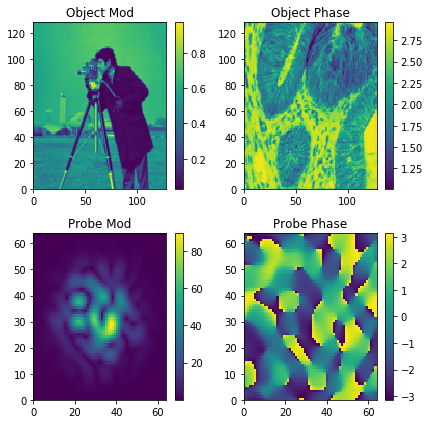

In [8]:
plt.figure(figsize=[6,6])
plot_items = [np.abs(obj_true), np.angle(obj_true), np.abs(probe_true), np.angle(probe_true)]
plot_titles = ['Object Mod', 'Object Phase', 'Probe Mod', 'Probe Phase']
for indx, item in enumerate(plot_items):
    plt.subplot(2, 2, indx + 1)
    plt.pcolormesh(item)
    plt.colorbar()
    plt.title(plot_titles[indx])
plt.tight_layout()
plt.show()

## Tensorflow reconstruction ##

Using a phase ramp for the position correction

In [9]:
# Initialize the probe with a backpropagation
# Random initalization for the object

probe_init = np.fft.fftshift(np.fft.ifft2(np.mean(np.sqrt(diff_intensities), axis=0)))
obj_init = np.random.random(obj_true.shape) * np.exp(1j * np.pi * np.random.random(obj_true.shape))

## Remove discontinuties in probe phase
angs = np.angle(probe_init)
angs[::2] += np.pi
angs[:,::2] += np.pi
probe_init = np.abs(probe_init) * np.exp(1j * angs)

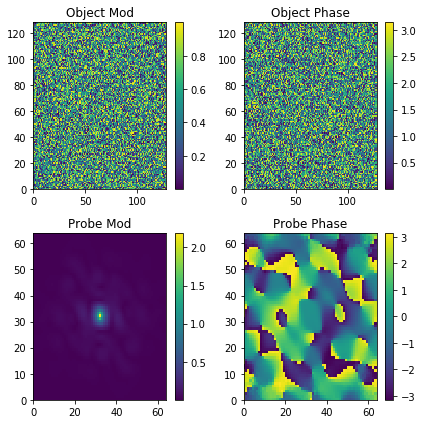

In [10]:
plt.figure(figsize=[6,6])
plot_items = [np.abs(obj_init), np.angle(obj_init), np.abs(probe_init), np.angle(probe_init)]
plot_titles = ['Object Mod', 'Object Phase', 'Probe Mod', 'Probe Phase']
for indx, item in enumerate(plot_items):
    plt.subplot(2, 2, indx + 1)
    plt.pcolormesh(item)
    plt.colorbar()
    plt.title(plot_titles[indx])
plt.tight_layout()
plt.show()

In [21]:
# Creating the variables for the reconstruction

tf.reset_default_graph()
tf_obj_real = tf.Variable(np.real(obj_init), dtype='float32')
tf_obj_imag = tf.Variable(np.imag(obj_init), dtype='float32')

tf_probe_real = tf.Variable(np.real(probe_init), dtype='float32')
tf_probe_imag = tf.Variable(np.imag(probe_init), dtype='float32')

tf_obj = tf.complex(tf_obj_real, tf_obj_imag)
tf_probe = tf.complex(tf_probe_real, tf_probe_imag)

ndiffs, npix, _ = diff_intensities.shape
shifted_intensities = np.fft.fftshift(diff_intensities, axes=(1,2))
tf_intensities = tf.constant(shifted_intensities, dtype='float32')

# Variable that holds the position shifts
tf_position_shifts = tf.Variable(np.zeros_like(grid_positions), dtype='float32')

In [22]:
# Defining the amplitude-based loss, using the entire data set at once.
# Creating batches is somewhat complicated, and beyond the scope of this notebook.
# This implmentation is simple conceptually but not the most efficient.
tf_obj_views_all = []
for i, (y, x) in enumerate(grid_positions):
    this_obj_view = tf_obj[y: y + npix, x: x + npix]
    tf_obj_views_all.append(this_obj_view)

tf_obj_views_all = tf.stack(tf_obj_views_all)

# position correction
# --------------------------------------------------------------------------------------------
tU, tV = tf.meshgrid(tf.range(npix, dtype='float32'), tf.range(npix, dtype='float32'))
tfactor = (-2 * np.pi* (tU * tf_position_shifts[:,1, None, None] 
                        + tV * tf_position_shifts[:,0,None,None]) / npix)
phase_ramp = tf.complex(tf.cos(tfactor), tf.sin(tfactor))

tf_exit_waves = tf_obj_views_all * tf.ifft2d(tf.fft2d(tf_probe) * batch_fftshift2d(phase_ramp))
# ----------------------------------------------------------------------------------------------
tf_fts = tf.fft2d(tf_exit_waves) / npix
loss = tf.reduce_mean((tf.abs(tf_fts) - tf.sqrt(tf_intensities))**2)

In [23]:
# For simplicity, I am using the Adam optimizer. 
# Using the lipschitz constants for the learning rates in a gradient descent process is quite complicated. 

# The learning rates were obtained through trial and error.
obj_optimizer = tf.train.AdamOptimizer(1e-2)
probe_optimizer = tf.train.AdamOptimizer(1e0)

probe_min = probe_optimizer.minimize(loss, var_list=[tf_probe_real, tf_probe_imag])
obj_min = obj_optimizer.minimize(loss, var_list=[tf_obj_real, tf_obj_imag])

position_opt = tf.train.AdamOptimizer(learning_rate=1e-3)
position_min = position_opt.minimize(loss, var_list=[tf_position_shifts])

In [24]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [25]:
lossvals_array = []

In [26]:
# Actual minimization procedure. 
# Minimizing both the probe and the object simultaneously.
for i in range(500):

    temp1, temp2, temp3, lossval = session.run([probe_min, obj_min, position_min, loss])
    if i % 50 == 0:
        print('Iterations = {i}   Loss = {lossval}'.format(i=i, lossval=lossval))
    
    lossvals_array.append(lossval)
    
    if lossval < 1e-5:
        break

recons_obj = session.run(tf_obj)
recons_probe = session.run(tf_probe)
print('Current loss is', lossvals_array[-1])

Iterations = 0   Loss = 45.898963928222656
Iterations = 50   Loss = 7.612412929534912
Iterations = 100   Loss = 4.577114105224609
Iterations = 150   Loss = 3.352309465408325
Iterations = 200   Loss = 0.9950098395347595
Iterations = 250   Loss = 0.6402002573013306
Iterations = 300   Loss = 0.5441828370094299
Iterations = 350   Loss = 0.4884868562221527
Iterations = 400   Loss = 0.45052939653396606
Iterations = 450   Loss = 0.42060497403144836
Current loss is 0.3962577


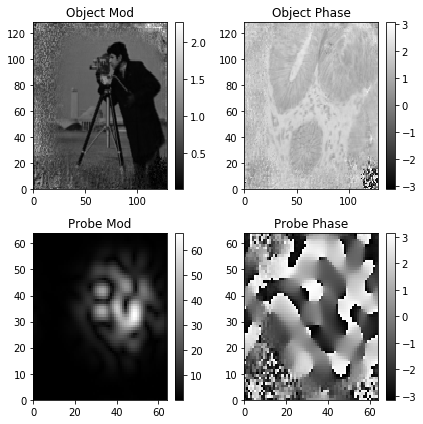

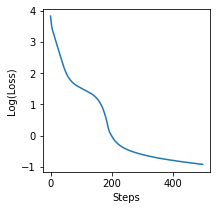

In [27]:
plt.figure(figsize=[6,6])
plot_items = [np.abs(recons_obj), np.angle(recons_obj),
              np.abs(recons_probe), np.angle(recons_probe)]
plot_titles = ['Object Mod', 'Object Phase', 'Probe Mod', 'Probe Phase']
for indx, item in enumerate(plot_items):
    plt.subplot(2, 2, indx + 1)
    plt.pcolormesh(item, cmap='gray')
    plt.colorbar()
    plt.title(plot_titles[indx])
plt.tight_layout()
plt.show()

plt.figure(figsize=[3,3])
plt.plot(np.log(lossvals_array))
plt.xlabel('Steps')
plt.ylabel('Log(Loss)')
plt.show()

In [28]:
# Calculating the reconstruction errors using the plane fitting procedure
# Note that the error thus calculated does not account for the lack of probe overlap at the edges of the object.
# Hence, the error calculated is an overestimate.
imgs, errs = registerImages(obj_true, recons_obj)
print('Reconstruction error', errs[1])


Reconstruction error 0.38325232492074374


/raid/home/skandel/code/ptychoSampling_v2/tensorflow_tutorials/helper.py:147: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params, residuals, rank, s = np.linalg.lstsq(a, b)


In [33]:
# Calculating the error in the corrected positions
grid_positions_new = session.run(tf_position_shifts) + grid_positions
error_before_recons = np.abs(grid_positions_correct - grid_positions).sum() / grid_positions.size
error_after_recons = np.abs(grid_positions_new - grid_positions).sum() / grid_positions.size

In [34]:
error_before_recons, error_after_recons

(0.65, 0.3477260856722569)